# Non-dimensional height of Svalbard
## Calculated from the UK Met Office Unified Model output (grid spacing: 2.2 km)

![Newtontoppen](https://upload.wikimedia.org/wikipedia/commons/7/7d/Newtontoppen.jpg)

## Import necessary packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
#
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import h5py
import iris
from iris.analysis.calculus import differentiate
from iris.experimental.stratify import relevel
import iris.pandas as ipd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import pandas as pd
import string
from pathlib import Path
import shapely.geometry as sgeom
from tqdm import tqdm
# My packages
import arke
import arke.met_const as mconst
# Local scripts
import mypaths

from common_defs import pl_cases, fcst_strs, hours, um_res
from plot_utils import map_kw, LCC_KW, AXGR_KW

In [2]:
# import stratify
# from functools import partial

In [3]:
pl_cases_inv = {v: k for k, v in pl_cases.items()}

In [4]:
plt.style.use('paperfig.mplstyle')

## Elevation data

In [5]:
run = 'ctrl'
subdirs = ['plev', 'sfc']

In [6]:
alt = iris.load_cube(str(mypaths.PATH_MASK).replace('umnsa_*', 'umnsa*000')
                                           .format(um_res=um_res,
                                                   fcst_init=fcst_strs[0],
                                                   idir=run,
                                                   subdir='sfc'),
                     'surface_altitude')

Height of Svalbard's highest mountain (Newtontoppen) in the model is roughly equal to 1277 m.

In [7]:
svalbard_region_elevation = alt[300:, 250:]

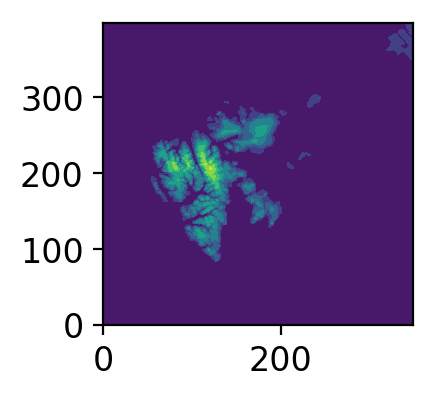

In [8]:
plt.figure(figsize=(2, 2))
plt.contourf(svalbard_region_elevation.data)

In [9]:
print(round(alt.data[300:, 250:].max()))

1277.0


In [10]:
svalbard_height = iris.coords.AuxCoord(1277, units='m')

Create linearly spaced array of height levels below the model's maximum height of Svalbard

In [11]:
nz = 12
z_target = np.linspace(1200, 100, nz)  # descending because otherwise relevel doesn't work

In [12]:
# It is also convenient to regrid altitude to the same grid as other variables ("unstagger")
# alt = alt.regrid(dict_of_cubelists[fcst].extract_strict('air_temperature'),
#                  iris.analysis.Linear())

Get unrotated longitudes and latitudes grid

In [13]:
lons, lats = arke.grid.unrotate_xy_grids(alt)

## Define averaging options

In [14]:
ave_opts = [('grid_longitude', 'grid_latitude', 'height'), iris.analysis.Aggregator('nan_mean', np.nanmean)]

In [15]:
lons.shape

(700, 600)

## Select a subset of data upstream of Svalbard
The subset's centre is roughly a Rossby radius of deformation, $\lambda=Nh/f$, away from Svalbard's peak.

In [16]:
# y_sub = slice(525, 675)
# x_sub = slice(475, 575)

# rdr = 150
y_sub = slice(554, 650)
x_sub = slice(419, 515)
# TODO: select by real coordinates instead of grid points

In [17]:
results_fname = mypaths.trackdir.parent / f'nondimhgt_series_x{x_sub.start}-{x_sub.stop}_y{y_sub.start}-{y_sub.stop}.h5'

## Calculate the non-dimensional height for both cases in one big loop

In [18]:
recalculate = False  # Recalculate the time series

Or load already calculated data

In [19]:
if recalculate or not results_fname.is_file():
    # Load the data
    dict_of_cubelists = dict()
    for fcst in tqdm(fcst_strs, desc='cases', leave=False):
        dict_of_cubelists[fcst] = iris.cube.CubeList()
        for subdir in tqdm(subdirs, desc='subdirs', leave=False):
            input_path = str(mypaths.PATH_MASK).format(um_res=um_res,
                                                       fcst_init=fcst,
                                                       idir=run,
                                                       subdir=subdir)
            cubelist = iris.load(input_path,
                                 callback=arke.io.clean_call)
            for cube in cubelist:
                add_attr = dict(subdir=subdir,
                                run=run,
                                um_res=um_res)
                cube.attributes.update(add_attr)
            dict_of_cubelists[fcst] += cubelist
    # The data are loaded from the last dictionary entry
    alt = dict_of_cubelists[fcst].extract_strict('surface_altitude')
    
    
    results = dict()
    for fcst in tqdm(fcst_strs, desc='cases'):
        # LOADING AND ADDITIONAL CALCULATIONS
        # Extract the necessary variables on pressure levels
        gh = dict_of_cubelists[fcst].extract_strict('geopotential_height')
        temp = dict_of_cubelists[fcst].extract_strict('air_temperature')
        # u- and v-wind components on pressure levels
        u = dict_of_cubelists[fcst].extract('x_wind').extract_strict(iris.AttributeConstraint(subdir='plev'))
        v = dict_of_cubelists[fcst].extract('y_wind').extract_strict(iris.AttributeConstraint(subdir='plev'))

        # Subset the variables
        gh = gh[..., y_sub, x_sub]
        temp = temp[..., y_sub, x_sub]
        u = u[..., y_sub, x_sub]
        v = v[..., y_sub, x_sub]

        # Mask out grid points that have invalid temperature values, i.e. are below the surface elevation
        # (not needed if the subset is over the sea)
        invalid_values = temp.data < 1
        # gh.data[invalid_values] = np.nan  # The source coordinate must not contain NaN values.
        temp.data[invalid_values] = np.nan
        u.data[invalid_values] = np.nan
        v.data[invalid_values] = np.nan

        # Calculate horizontal wind speed
        wspd = (u ** 2 + v ** 2) ** 0.5
        wspd.rename('horizontal_wind_speed')

        # Create an array of atmospheric pressure from the pressure levels on which the variables are loaded
        pres = arke.coords.pres_coord_to_cube(temp)

        # REGRID DATA TO HEIGHT LEVELS
        # Vertical regridding options
        ## interpolator = partial(stratify.interpolate,
        ##                        interpolation=stratify.INTERPOLATE_NEAREST,
        ##                        extrapolation=stratify.EXTRAPOLATE_NEAREST)
        relevel_kw = dict(src_levels=gh, tgt_levels=z_target, axis='pressure')#, interpolator=interpolator))

        # Regrid the cubes
        wspd_z = relevel(wspd, **relevel_kw)
        temp_z = relevel(temp, **relevel_kw)
        pres_z = relevel(pres, **relevel_kw)
        # Rename the z-coordinate
        for cube in [wspd_z, temp_z, pres_z]:
            cube.coord('geopotential_height').rename('height')
            cube.coord('height').attributes = {}

        # BRUNT_VAISALA CALCULATION
        # Calculate potential temperature
        thta_z = arke.met_calc.potential_temperature(pres_z, temp_z)

        # Calculate vertical derivative of theta
        # $\frac{\partial \theta}{\partial z}$
        # and linearly interpolate to the same levels as theta itself
        dthta_dz = (differentiate(thta_z, 'height')
                    .interpolate([('height',
                                   thta_z.coord('height').points)],
                                 iris.analysis.Linear()))

        # Create a gravitational constant quantity with units
        g_aux = iris.coords.AuxCoord(points=arke.met_const.g.data, units=arke.met_const.g.units)

        # Calculate Brunt-Vaisala frequency
        # Calculate the buoyancy frequency using the standard definition
        # $N^2 = \frac{g}{\theta}\frac{\partial \theta}{\partial z}$
        bvfreq = (((thta_z / g_aux) ** (-1)) * dthta_dz) ** 0.5
        bvfreq.rename('brunt_vaisala_frequency')
        bvfreq.convert_units('s-1')

        # Average the Brunt-Vaisala frequency ($N$) and the wind speed ($U$) separately
        # The averaging is done for all coordinates, except time
        spatially_mean_bvfreq = bvfreq.collapsed(*ave_opts)
        spatially_mean_wspd = wspd_z.collapsed(*ave_opts)

        # CALCULATE THE NON_DIMENSIONAL HEIGHT
        non_dim_height = svalbard_height * spatially_mean_bvfreq / spatially_mean_wspd
        assert (non_dim_height.units.is_dimensionless(),
                'The cube of non-dim. height is not dimensionless, check the calculation!')

        # Store the final time series in a DataFrame
        res_df = pd.DataFrame(data=dict(U=iris.pandas.as_series(spatially_mean_wspd),
                                        N=iris.pandas.as_series(spatially_mean_bvfreq),
                                        H=iris.pandas.as_series(non_dim_height)))
        # Save it to an HDF file for convenience
        res_df.to_hdf(results_fname, key=fcst, mode='a')

        # Store the dataframe in a dictionary for further analysis
        results[fcst] = res_df
else:
    results = dict()
    for fcst in tqdm(fcst_strs, desc='cases'):
        results[fcst] = pd.read_hdf(results_fname, key=fcst)

cases: 100%|██████████| 2/2 [00:00<00:00, 18.83it/s]


## Recalculate the Rossby deformation radius

In [20]:
rossby_def_rad = np.mean([(results[fcst].N * svalbard_height.points / 1.4e-1).mean() for fcst in fcst_strs])

In [21]:
print(rossby_def_rad)

161.67044911089636


In [22]:
svalbard_region_elevation = alt[300:, 250:]

In [23]:
iy, ix = np.unravel_index(svalbard_region_elevation.data.argmax(), svalbard_region_elevation.shape)

In [24]:
rot_lat = svalbard_region_elevation[iy, ix].coord('grid_latitude').points
rot_lon = svalbard_region_elevation[iy, ix].coord('grid_longitude').points

In [25]:
nplon = svalbard_region_elevation.coord_system().grid_north_pole_longitude
nplat = svalbard_region_elevation.coord_system().grid_north_pole_latitude
true_lon, true_lat = iris.analysis.cartography.unrotate_pole(rot_lon, rot_lat, nplon, nplat)
true_lon, true_lat = true_lon[0], true_lat[0]

In [26]:
dx = round(((rossby_def_rad **2 / 2) ** 0.5) / um_res.to_flt('km'))

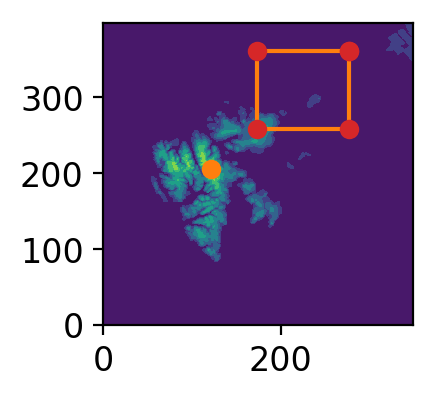

In [27]:
plt.figure(figsize=(2, 2))
plt.contourf(svalbard_region_elevation.data)
plt.plot(ix, iy, marker='o', mfc='C1', mec='C1')

plt.plot([ix+dx*3, ix+dx, ix+dx, ix+dx*3, ix+dx*3],
         [iy+dx*3, iy+dx*3, iy+dx, iy+dx, iy+dx*3],
         marker='o', mfc='C3', mec='C3')

In [28]:
LCC_KW['ticks'] = [5, 2]
LCC_KW['extent'] = [0, 40, 75, 83]

In [29]:
vrbls = [
    dict(key='N', label='$N$', plt_kw=dict(color='C0', linewidth=0.75), ylim=[0.010, 0.025], ylabel=u'Brunt–Väisälä frequency', xytext=(-15, 5)),
    dict(key='U', label='$U$', plt_kw=dict(color='C1', linewidth=0.75), ylim=[0, 15], ylabel='Wind speed', xytext=(-15, -15)),
    dict(key='H', label='$\hat{h}$', plt_kw=dict(color='C2', linewidth=1.5), ylim=[1, 5.5], ylabel='Nondimensional height', xytext=(-15, 5)),
]
x_axis_color = '#777777'

In [30]:
glon = alt.coord('grid_longitude').points
glat = alt.coord('grid_latitude').points
bbox = [glon[419]-360, glon[515]-360, glat[554], glat[650]]
crs = svalbard_region_elevation.coord_system().as_cartopy_crs()

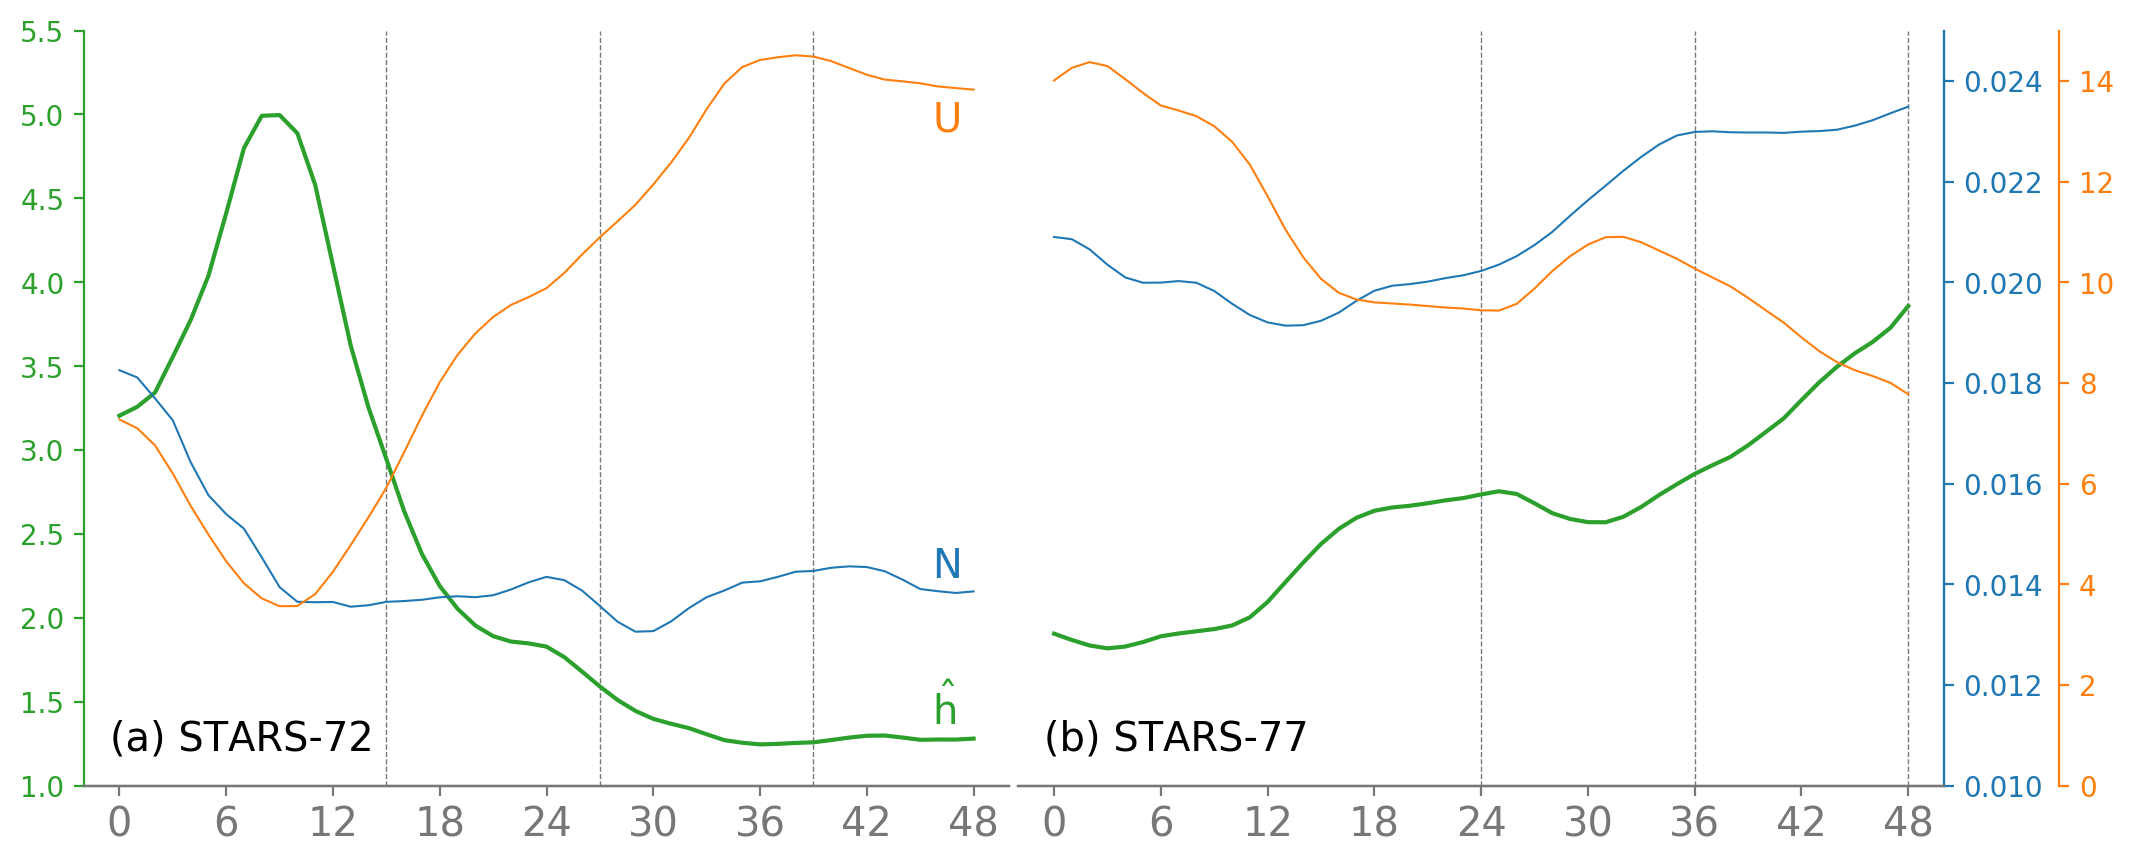

In [31]:
fig = plt.figure(figsize=(12, 5))

axlabels = iter(string.ascii_lowercase)

# # Map to show key points
# ax_map = arke.cart.lcc_map(fig, 131, **LCC_KW)
# ax_map.tick_params(labelsize='x-small')
# ax_map.tick_params(axis='x', labelrotation=45)
# txt = f'({next(axlabels)})'
# at = AnchoredText(txt, borderpad=0.25, prop=dict(size='large'), frameon=False, loc=3)
# ax_map.add_artist(at)

# ax_map.plot(true_lon, true_lat, marker='^', color='k', **map_kw)
# ax_map.annotate(f'{svalbard_height.points[0]} m',
#                 xy=(true_lon, true_lat), xycoords='data',
#                 xytext=(30, 60), textcoords='offset points',
#                 size='small', ha='center',
#                 path_effects=[PathEffects.withStroke(linewidth=1,
#                                                     foreground='w')],
#                 **map_kw)

# extent_box = sgeom.box(bbox[0], bbox[2], bbox[1], bbox[3])
# ax_map.add_geometries([extent_box], crs=crs, hatch='//////', color='none', edgecolor='blue', linewidth=0);

for i, fcst in enumerate(fcst_strs):
    df = results[fcst]
    fcst_hours = [int(i.total_seconds() / 3600)
                  for i in df.index - df.index[0]]
    ax = fig.add_subplot(121+i)
    
    _hours = hours[pl_cases_inv[fcst]]
    for j, vrbl in enumerate(vrbls):
        color = vrbl['plt_kw']['color']
        if j == 2:
            if i == 0:
                ax.spines['left'].set_edgecolor(color)
            _ax = ax
        else:
            _ax = ax.twinx()
        _ax.plot(fcst_hours, df[vrbl['key']].values,
                 label=vrbl['label'], **vrbl['plt_kw'])
#         _ax.plot(_hours, df[vrbl['key']].values[_hours],
#                  linestyle='', color=color, ms=4, marker=vrbl['symbol'])
        _ax.set_ylim(vrbl['ylim'])
#         _ax.set_ylabel(f"{vrbl['ylabel']} ({vrbl['label']})", fontsize='xx-small', color=color)
        _ax.tick_params(axis='y', labelsize='small',
                        color=color, labelcolor=color)
        _ax.spines['top'].set_visible(False)
        
        if i == 0:
            _ax.annotate(vrbl['label'],
                xy=(fcst_hours[-1], df[vrbl['key']].values[-1]), xycoords='data',
                xytext=vrbl['xytext'], textcoords='offset points',
                size='large',
                color=color)
        
        if i == 0:
            if j != 2:
                _ax.set_yticks([])
                _ax.spines['right'].set_visible(False)
                _ax.spines['left'].set_visible(False)
                ax.spines['right'].set_visible(False)
        elif i == 1:
            if j == 2:
                _ax.set_yticks([])
            _ax.spines['left'].set_visible(False)
            if j == 1:
                _ax.spines['right'].set_position(('axes', 1.125))
            _ax.spines['right'].set_edgecolor(color)
        _ax.spines['bottom'].set_edgecolor(x_axis_color)
        _ax.tick_params(axis='x', labelsize='large',
                        color=x_axis_color, labelcolor=x_axis_color)

    ax.vlines(_hours, *ax.get_ylim(), linewidth=0.5, linestyles='--', colors=x_axis_color)
    ax.set_xticks(range(0, 49, 6))
    ax.set_xlim(-2, 50)
    txt = f'({next(axlabels)}) {pl_cases_inv[fcst].replace("STARS", "STARS-")}' # 
    at = AnchoredText(txt, borderpad=0.25, prop=dict(size='large'), frameon=False, loc=3)
    ax.add_artist(at)

fig.subplots_adjust(wspace=0.01)

In [32]:
fig.savefig(str(mypaths.plotdir / f'nondim_height_series'))

### Map to show key points

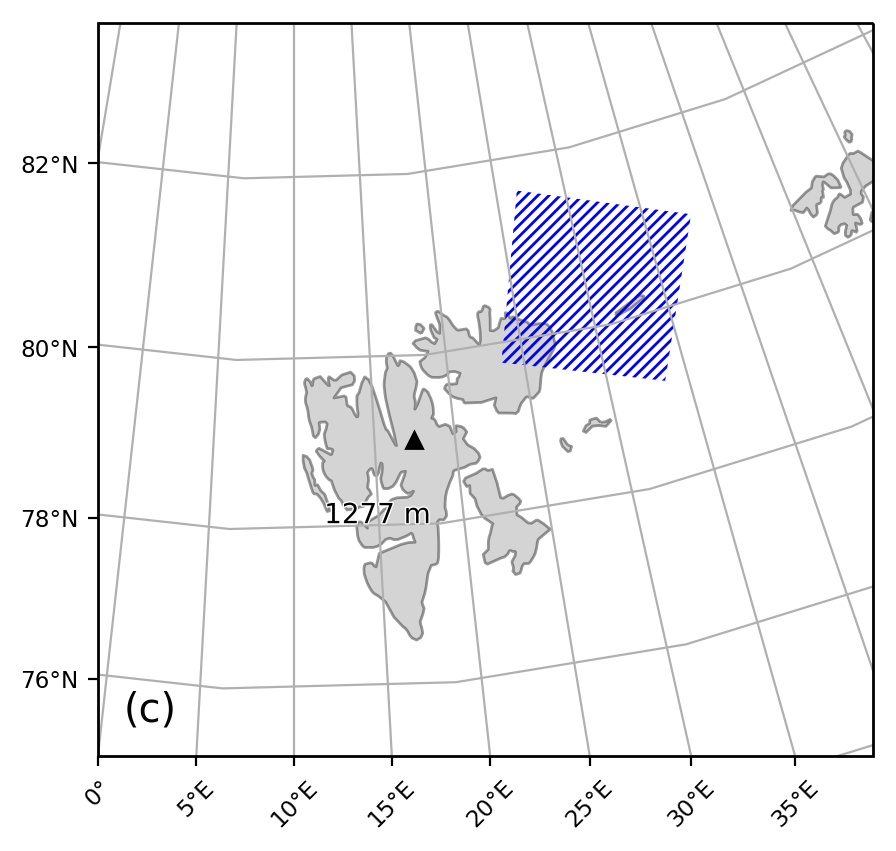

In [33]:
fig = plt.figure(figsize=(5, 5))
ax_map = arke.cart.lcc_map(fig, 111, **LCC_KW)
ax_map.tick_params(labelsize='x-small')
ax_map.tick_params(axis='x', labelrotation=45)
txt = f'({next(axlabels)})'
at = AnchoredText(txt, borderpad=0.25, prop=dict(size='large'), frameon=False, loc=3)
ax_map.add_artist(at)

ax_map.plot(true_lon, true_lat, marker='^', color='k', **map_kw)
ax_map.annotate(f'{svalbard_height.points[0]} m',
                xy=(true_lon, true_lat), xycoords='data',
                xytext=(30, 60), textcoords='offset points',
                size='small', ha='center',
                path_effects=[PathEffects.withStroke(linewidth=1,
                                                    foreground='w')],
                **map_kw)

extent_box = sgeom.box(bbox[0], bbox[2], bbox[1], bbox[3])
ax_map.add_geometries([extent_box], crs=crs, hatch='//////', color='none', edgecolor='blue', linewidth=0);